In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
import torch

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd /content/drive/MyDrive/DeepLearning/yoga 
# !find . -name ".DS_Store" -delete

# Load In Data

In [ ]:
%%time
# dataset/poses/image
labels = [] #label for each image
images = []
pose_mapping = dict()
images_path = []
images_pixels = []
not_image_pose = []
not_image = []

i = 0
# data_dir = "./yoga"
data_dir = "/content/drive/MyDrive/DeepLearning/yoga"

# data_dir = "/content/drive/MyDrive/yoga"


for pose in os.listdir(data_dir):
    pose_mapping[i] = pose
    subdir = os.path.join(data_dir,pose)
    for img in os.listdir(subdir): # loop over all images in this dir
        img_path = os.path.join(subdir,img)
        images_path.append(img_path)
        img_pix_bgr = cv2.imread(img_path,1) #stored in cv::Mat object#not resize yet #1:order of colors=BGR 8-bit format
        if img_pix_bgr is None:
            print(f"{img} in {pose} cannot be read")
            not_image_pose.append(pose)
            not_image.append(img)
            continue
        # add only if it IS an image
        img_pix_rgb = cv2.cvtColor(img_pix_bgr, cv2.COLOR_BGR2RGB) #BGR converted to RGB
        images_pixels.append(img_pix_rgb)
        images.append(img)
        labels.append(i)
        
    i += 1 #next pose dir: new label

File62.gif in warrior pose cannot be read
File36.gif in warrior pose ii cannot be read
CPU times: user 36.2 s, sys: 4.84 s, total: 41.1 s
Wall time: 31min 14s


In [ ]:
print(f"Ignoring GIF,there are {len(images)} images.")

Ignoring GIF,there are 5999 images.


In [ ]:
label_mapping = pd.DataFrame.from_dict(pose_mapping,"index") #keys of passed dict are rows
label_mapping = label_mapping.reset_index()
label_mapping.columns = ["label","pose"]
label_mapping.head()

,label,pose
0,0,grasshopper pose
1,1,garland pose
2,2,big toe pose
3,3,sage twist pose
4,4,extended triangle pose


In [ ]:
import pickle

mylist = label_mapping['pose'].tolist()

with open('labeling.pkl', 'wb') as f:
   pickle.dump(mylist, f)
 

In [ ]:
from google.colab import files
files.download('labeling.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Initial Cleaning
- convert GIF to PNG

In [ ]:
gifs = []
for pose,img in zip(not_image_pose,not_image):
    gifs.append(os.path.join(data_dir,pose,img))

In [ ]:
def gif_png(path,delete=False):
    """convert GIF to PNG,whether to delete original GIF file"""
    filepath,filename = os.path.split(path) #'./yoga/supine spinal twist pose' 'File36.gif'
    filtername,ext = os.path.splitext(filename) #('File36', '.gif')
    outfile = filtername + ".png"
    if filename != outfile:
        try:
            with Image.open(path) as im:
                im.save(os.path.join(filepath,outfile))
                print(f"{filename} has been successfully converted to {outfile}")                
                if delete:
                    os.remove(path)
                    print(f"{filename} has been deleted")
        except OSError:
            print("cannot convert", filename)
    return filtername,os.path.join(filepath,outfile)

In [ ]:
gifs

['/content/drive/MyDrive/DeepLearning/yoga/warrior pose/File62.gif',
 '/content/drive/MyDrive/DeepLearning/yoga/warrior pose ii/File36.gif']

In [ ]:
for gif in gifs:
    name_without_ext,png_path = gif_png(gif,False)
    
    # add two new png into dataset
    images.append(name_without_ext+".png")
    # add two png's full path
    images_path.append(png_path)
    # add two png's pixels
    img_pix_bgr = cv2.imread(png_path,1)
    img_pix_rgb = cv2.cvtColor(img_pix_bgr, cv2.COLOR_BGR2RGB) 
    images_pixels.append(img_pix_rgb)

File62.gif has been successfully converted to File62.png
File36.gif has been successfully converted to File36.png


In [ ]:
# add labels
for pose in not_image_pose:
    labels.append(label_mapping.loc[label_mapping["pose"] == pose,"label"].iloc[0])

In [ ]:
print(f"After initial cleaning,there are total {len(images)} images")
print(f"There are {len(pose_mapping.keys())} different poses in dataset")

After initial cleaning,there are total 6001 images
There are 107 different poses in dataset


## Visualize some of the data

show first 6 images in first class

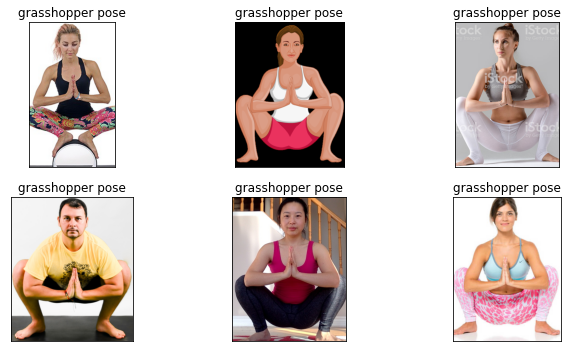

In [ ]:
class_dir = '/content/drive/MyDrive/DeepLearning/yoga/garland pose'

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(os.path.join(class_dir, os.listdir(class_dir)[i])))
    ax.set_title(os.listdir(data_dir)[0])
plt.tight_layout()
plt.show()

In [ ]:
## count number of images in each class
df_count = pd.DataFrame(columns=['class','count'])
df_count['class']=pd.Series([os.listdir(data_dir)[x] for x in range(0,107)])
df_count['count']=pd.Series([len(os.listdir(os.path.join(data_dir,os.listdir(data_dir)[x]))) for x in range(0,107)])
df_count
# df_count.sort_values(by=['count'])

,class,count
0,grasshopper pose,62
1,garland pose,68
2,big toe pose,18
3,sage twist pose,49
4,extended triangle pose,69
...,...,...
102,four-limbed staff pose,90
103,lion pose,49
104,chair pose,73
105,crane pose,77


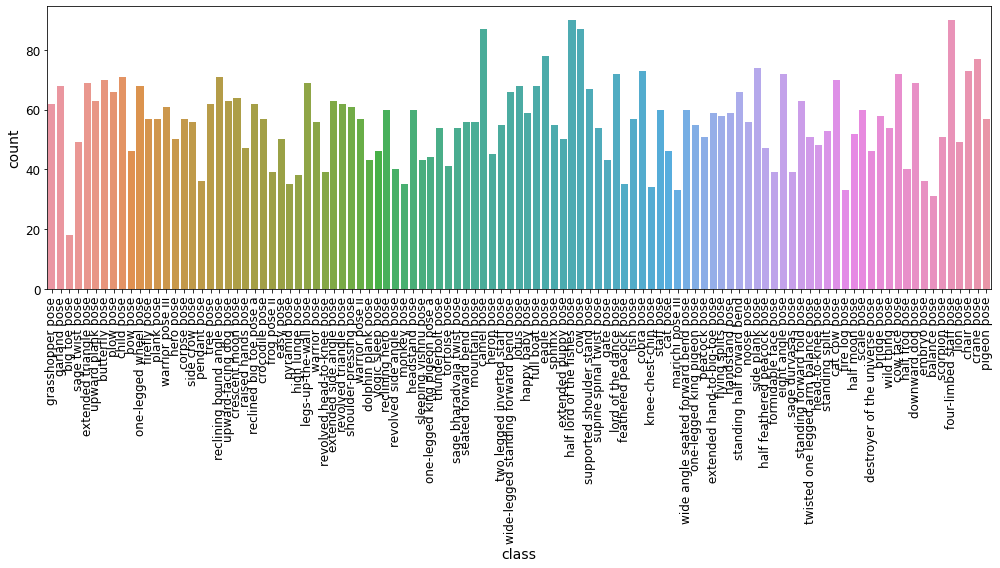

In [ ]:
import seaborn as sns
plt.figure(figsize=(14,8))
g=sns.barplot(x='class', y='count', data=df_count)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()

(numpy.ndarray, dtype('float32'), (333, 198, 3))

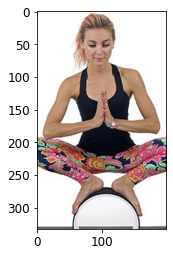

In [ ]:
## display the first image in first class
first_fir = plt.imread(os.path.join(class_dir, os.listdir(class_dir)[0]))
plt.imshow(first_fir)

## print out type and shape of the image
type(first_fir), first_fir.dtype, first_fir.shape, 

(numpy.ndarray, dtype('float32'), (143, 354, 3))

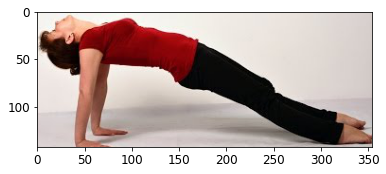

In [ ]:
## display the first image in the second class
class2_dir = '/content/drive/MyDrive/DeepLearning/yoga/upward plank pose'

first_sec = plt.imread(os.path.join(class2_dir, os.listdir(class2_dir)[0]))
plt.imshow(first_sec)

## print out type and shape of the image
type(first_sec), first_sec.dtype, first_sec.shape, 

(numpy.ndarray, dtype('float32'), (281, 422, 3))

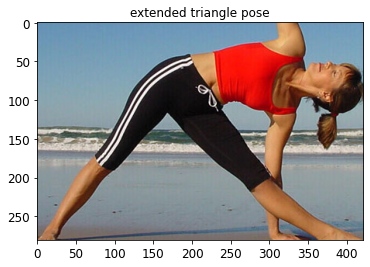

In [ ]:
## display the first image in third class
class3_dir = '/content/drive/MyDrive/DeepLearning/yoga/extended triangle pose'

first_third = plt.imread(os.path.join(class3_dir, os.listdir(class3_dir)[0]))
plt.imshow(first_third)
plt.title('extended triangle pose')

## print out type and shape of the image
type(first_third), first_third.dtype, first_third.shape, 

Text(0.5, 1.0, 'firstInfirst Histogram')

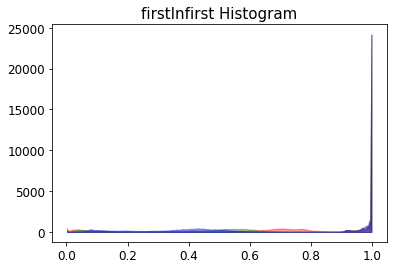

In [ ]:
## plot histogram
import skimage
from skimage import data, io, filters, color, exposure
from skimage.transform import rotate

for col, channel in zip('rgb', np.rollaxis(first_fir, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
plt.title('firstInfirst Histogram', fontsize=15)

Text(0.5, 1.0, 'firstInsecond Histogram')

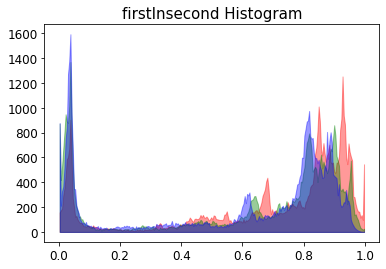

In [ ]:
for col, channel in zip('rgb', np.rollaxis(first_sec, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
plt.title('firstInsecond Histogram', fontsize=15)

Text(0.5, 1.0, 'firstInthird Histogram')

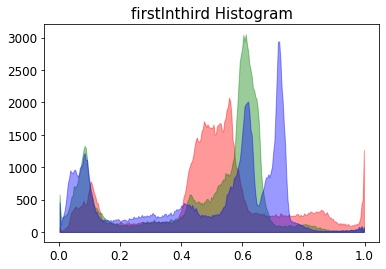

In [ ]:
for col, channel in zip('rgb', np.rollaxis(first_third, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
plt.title('firstInthird Histogram', fontsize=15)

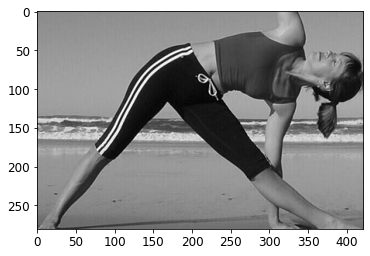

In [ ]:
#convert image to grey scale and display
first_third_gray = color.rgb2gray(first_third)
plt.imshow(first_third_gray)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  


Text(0.5, 1.0, 'first_third_gray Histogram')

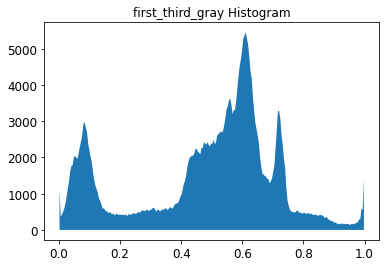

In [ ]:
#plot histogram of intensities using Skimage API
hist, bin_centers = exposure.histogram(first_third)
plt.fill_between(bin_centers, hist)
plt.title("first_third_gray Histogram")

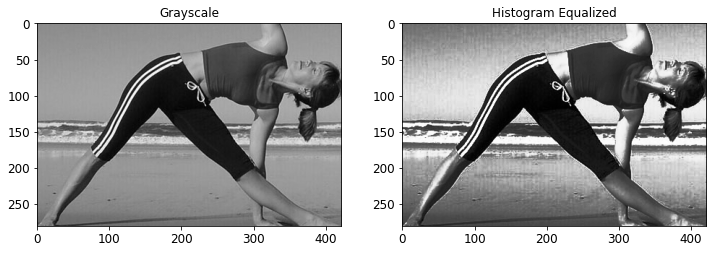

In [ ]:
from skimage.exposure import equalize_hist

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

first_third_gray_equalized = equalize_hist(first_third_gray)

show_images(images=[first_third_gray, first_third_gray_equalized],
            titles=["Grayscale","Histogram Equalized"])

Text(0.5, 1.0, 'first_third_gray Equalized')

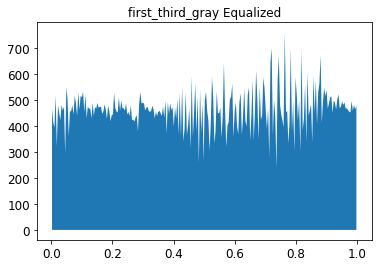

In [ ]:
#plot histogram of intensities using Skimage API
hist, bin_centers = exposure.histogram(first_third_gray_equalized)
plt.fill_between(bin_centers, hist)
plt.title("first_third_gray Equalized")

Text(0.5, 1.0, 'Adaptive Histogram equalization')

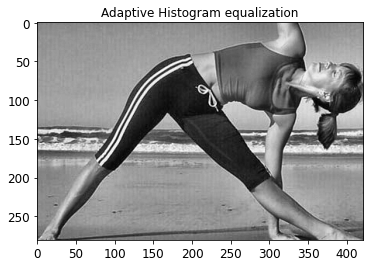

In [ ]:
import cv2 as cv
img = os.path.join(class3_dir, os.listdir(class3_dir)[0])
img = cv.imread(img,0)

# create a CLAHE object
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
plt.imshow(cl1)
plt.title('Adaptive Histogram equalization')

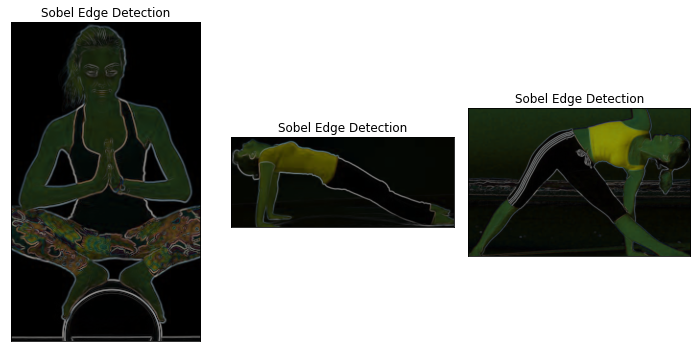

In [ ]:
## Sobel Edge Detection
from skimage import filters

edge_sobel = []
img = [first_fir, first_sec, first_third]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    # edge_sobel = filters.sobel(img[j])
    ax.imshow(filters.sobel(img[i]), cmap=plt.cm.gray)
    ax.set_title('Sobel Edge Detection')

plt.tight_layout()
plt.show()

In [ ]:
# try some data augmentation
data_augmentation = tf.keras.Sequential(
    [keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      keras.layers.experimental.preprocessing.RandomRotation(0.1),
      keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

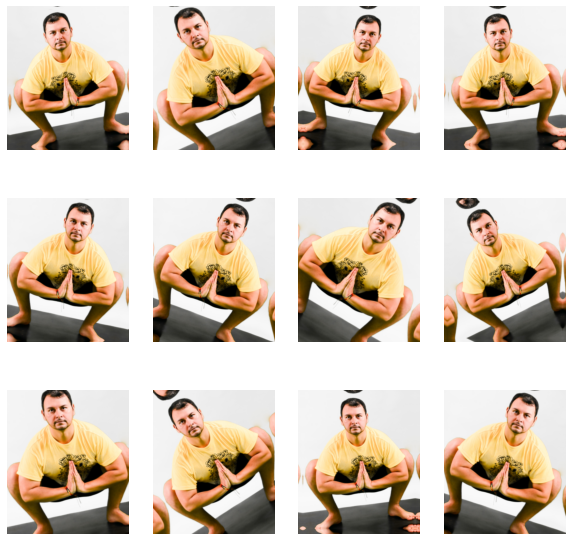

In [ ]:
# take one image to see the results
image = plt.imread(os.path.join(class_dir, os.listdir(class_dir)[3]))
plt.figure(figsize=(10, 10))

for i in range(12):
    plt.subplot(3, 4, i + 1) 
    augmented_image = data_augmentation(            
        tf.expand_dims(image, 0)
        )
    plt.imshow(augmented_image[0])
    plt.axis("off")

basic preprocessing, create and split the data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RandomRotation

train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  zoom_range= 0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  validation_split=0.15)

In [5]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')

Found 5143 images belonging to 107 classes.


In [23]:
label_mapping = train_data.class_indices #dict key=pose name;value=index
# inverse mapping key=index
index_mapping = {}
for k,v in label_mapping.items():
  index_mapping[v] = k

In [32]:
# download label mapping to pickle file
import pickle
pose_list = list(index_mapping.values())

with open('labeling.pkl', 'wb') as f:
   pickle.dump(pose_list, f)


In [33]:
from google.colab import files
files.download('labeling.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(32, 224, 224, 3)


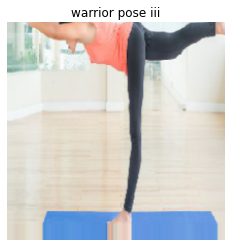

(32, 224, 224, 3)


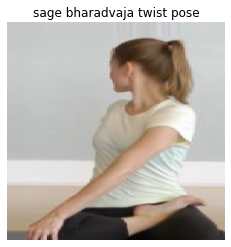

(32, 224, 224, 3)


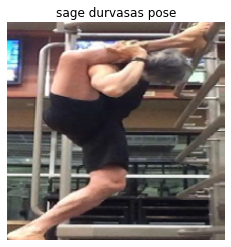

(32, 224, 224, 3)


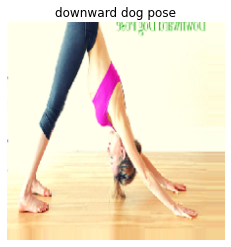

In [24]:
for i in range(4):
    img, label = train_data.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    idx = np.argmax(label[0])
    pose_name = index_mapping[idx]
    plt.title(pose_name)
    plt.axis("off")
    plt.show()


In [ ]:
images, labels = next(iter(train_data))
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32, 107)


In [17]:
validation_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

Found 848 images belonging to 107 classes.


# Model Building

## CNN model

In [ ]:
model_cnn = tf.keras.models.Sequential([Conv2D(128,(3,3),input_shape=(224,224,3),activation='relu'),
                    BatchNormalization(),                  
                    Conv2D(128,(3,3),activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(64,(3,3),activation='relu'),
                    BatchNormalization(),
                    Conv2D(64,(3,3),activation='relu'),
                    MaxPool2D(2,2),
                    Dropout(0.25),
                    Conv2D(32,(3,3),activation='relu'),
                    BatchNormalization(),
                    Conv2D(32,(3,3),activation='relu'),
                    BatchNormalization(), 
                    MaxPool2D(2,2),
                    Flatten(),
                    Dense(1024,activation='relu'),
                    Dense(512,activation='relu'),
                    Dropout(0.25), 
                    Dense(107,activation='softmax')])

In [ ]:
#compile
model_cnn.compile(loss='categorical_crossentropy', optimizer="nadam", metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    history = model_cnn.fit(train_data, validation_data = validation_data, epochs=100, verbose=1)

Epoch 1/100
 46/161 [=======>......................] - ETA: 1:09 - loss: 5.4176 - accuracy: 0.0190

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


161/161 [==============================] - 115s 699ms/step - loss: 4.8495 - accuracy: 0.0311 - val_loss: 4.5426 - val_accuracy: 0.0342
Epoch 2/100
161/161 [==============================] - 111s 688ms/step - loss: 4.3225 - accuracy: 0.0638 - val_loss: 4.1533 - val_accuracy: 0.0767
Epoch 3/100
161/161 [==============================] - 111s 691ms/step - loss: 3.9761 - accuracy: 0.1071 - val_loss: 5.1938 - val_accuracy: 0.0767
Epoch 4/100
161/161 [==============================] - 111s 690ms/step - loss: 3.6186 - accuracy: 0.1506 - val_loss: 3.7698 - val_accuracy: 0.1215
Epoch 5/100
161/161 [==============================] - 111s 690ms/step - loss: 3.3552 - accuracy: 0.1872 - val_loss: 3.2023 - val_accuracy: 0.2323
Epoch 6/100
161/161 [==============================] - 112s 694ms/step - loss: 3.1132 - accuracy: 0.2204 - val_loss: 2.9701 - val_accuracy: 0.2783
Epoch 7/100
161/161 [==============================] - 111s 690ms/step - loss: 2.9235 - accuracy: 0.2797 - val_loss: 3.1104 - val_

Text(0.5, 1.0, 'Loss Curves')

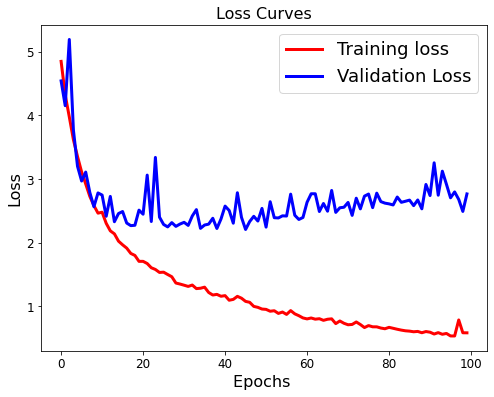

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

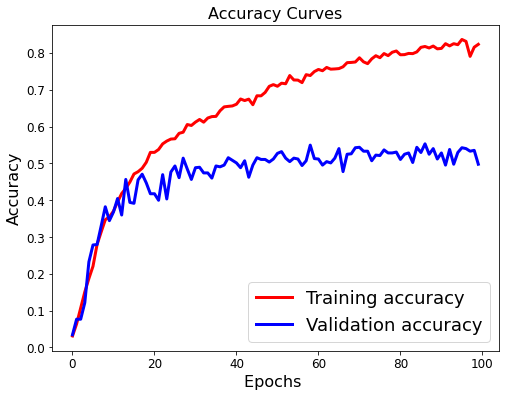

In [ ]:
# Accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model_cnn.evaluate(validation_data)

27/27 [==============================] - 16s 557ms/step - loss: 2.7054 - accuracy: 0.5236


[2.7053792476654053, 0.5235849022865295]

## Transfer Learning -- DenseNet201

In [ ]:
base_model = keras.applications.DenseNet201(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = Dropout(0.25)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(107, activation="softmax", name="classification")(x)
model_tf = tf.keras.Model(inputs=base_model.input, outputs = outputs)

In [ ]:
model_tf.compile(loss="categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
history_tf = model_tf.fit(train_data,
                    validation_data=validation_data,
                    epochs=25, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=3,restore_best_weights=True)]
                    )

Epoch 1/25
 23/161 [===>..........................] - ETA: 2:19 - loss: 4.6289 - accuracy: 0.0508

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


161/161 [==============================] - 217s 941ms/step - loss: 3.2868 - accuracy: 0.2043 - val_loss: 3.6906 - val_accuracy: 0.2358
Epoch 2/25
161/161 [==============================] - 135s 836ms/step - loss: 1.9422 - accuracy: 0.4490 - val_loss: 2.3752 - val_accuracy: 0.3632
Epoch 3/25
161/161 [==============================] - 134s 829ms/step - loss: 1.4713 - accuracy: 0.5580 - val_loss: 2.2945 - val_accuracy: 0.4092
Epoch 4/25
161/161 [==============================] - 134s 829ms/step - loss: 1.2280 - accuracy: 0.6290 - val_loss: 1.9069 - val_accuracy: 0.4847
Epoch 5/25
161/161 [==============================] - 133s 823ms/step - loss: 1.0851 - accuracy: 0.6686 - val_loss: 1.6136 - val_accuracy: 0.5637
Epoch 6/25
161/161 [==============================] - 130s 805ms/step - loss: 0.9732 - accuracy: 0.6964 - val_loss: 1.5921 - val_accuracy: 0.5649
Epoch 7/25
161/161 [==============================] - 130s 808ms/step - loss: 0.8447 - accuracy: 0.7254 - val_loss: 1.6826 - val_accura

In [ ]:
model_tf.evaluate(validation_data)

27/27 [==============================] - 16s 574ms/step - loss: 1.3185 - accuracy: 0.6403


[1.3185306787490845, 0.6403301954269409]

In [ ]:
# model_save_name = 'Densenet201_model.h5'
# path = F"/content/drive/MyDrive/{model_save_name}" 
# torch.save(model_tf, path)

model_tf.save('densenet201.h5')

INFO:tensorflow:Assets written to: ram://107711f5-6181-4fa5-ae81-abd532b6e9eb/assets


Text(0.5, 1.0, 'Loss Curves')

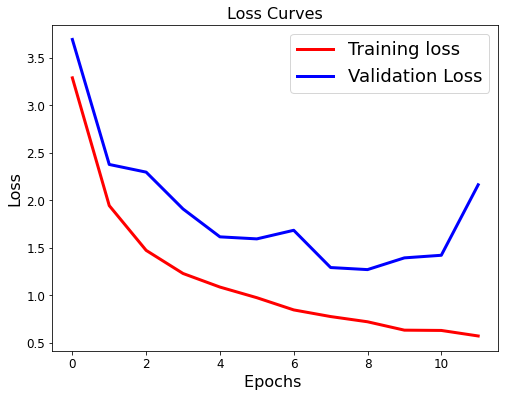

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history_tf.history['loss'],'r',linewidth=3.0)
plt.plot(history_tf.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'accuracy Curves')

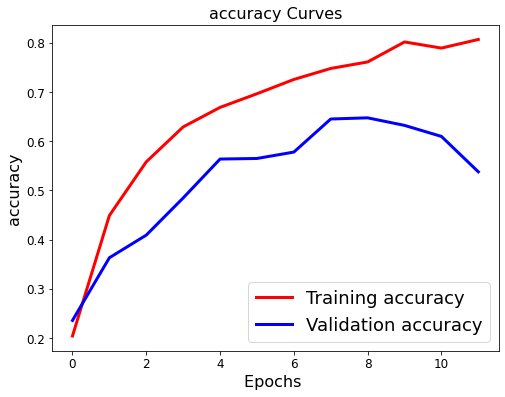

In [ ]:
# accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history_tf.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_tf.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.title('accuracy Curves',fontsize=16)

## Transfer Learning test2-- Resnet50

In [ ]:
#inputs = tf.keras.layers.Input(shape=(224,224,3))
base_model = keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = Dropout(0.25)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(107, activation="softmax", name="classification")(x)
model_tf2 = tf.keras.Model(inputs=base_model.input, outputs = outputs)

In [ ]:
model_tf2.compile(loss="categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
history_tf2 = model_tf2.fit(train_data,
                    validation_data=validation_data,
                    epochs=25, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=3,restore_best_weights=True)]
                    )

Epoch 1/25
 18/161 [==>...........................] - ETA: 1:40 - loss: 4.7452 - accuracy: 0.0365

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


161/161 [==============================] - 154s 818ms/step - loss: 3.4900 - accuracy: 0.1724 - val_loss: 6.8849 - val_accuracy: 0.0118
Epoch 2/25
161/161 [==============================] - 120s 747ms/step - loss: 2.1283 - accuracy: 0.4078 - val_loss: 8.2316 - val_accuracy: 0.0118
Epoch 3/25
161/161 [==============================] - 118s 734ms/step - loss: 1.6464 - accuracy: 0.5137 - val_loss: 5.2555 - val_accuracy: 0.0708
Epoch 4/25
161/161 [==============================] - 116s 722ms/step - loss: 1.3527 - accuracy: 0.5920 - val_loss: 4.1506 - val_accuracy: 0.1250
Epoch 5/25
161/161 [==============================] - 116s 721ms/step - loss: 1.1590 - accuracy: 0.6352 - val_loss: 2.1464 - val_accuracy: 0.4222
Epoch 6/25
161/161 [==============================] - 116s 718ms/step - loss: 1.0276 - accuracy: 0.6744 - val_loss: 1.4322 - val_accuracy: 0.6002
Epoch 7/25
161/161 [==============================] - 116s 719ms/step - loss: 0.9173 - accuracy: 0.7015 - val_loss: 1.7297 - val_accura

In [ ]:
model_tf2.evaluate(validation_data)

27/27 [==============================] - 15s 544ms/step - loss: 1.5223 - accuracy: 0.5637


[1.522265076637268, 0.5636792182922363]

Text(0.5, 1.0, 'Loss Curves')

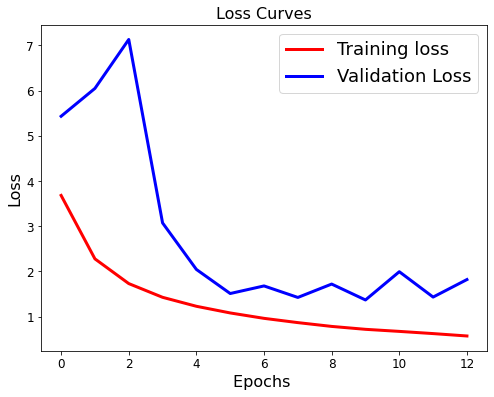

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history_tf2.history['loss'],'r',linewidth=3.0)
plt.plot(history_tf2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'accuracy Curves')

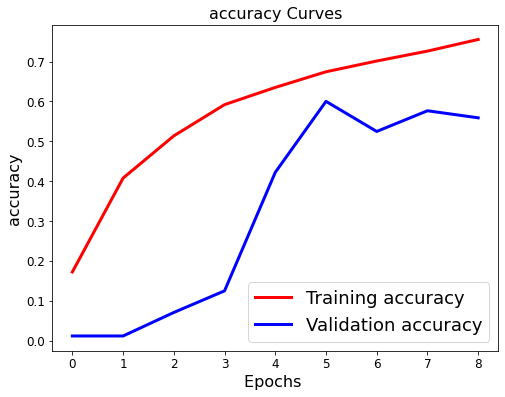

In [ ]:
# accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history_tf2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_tf2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.title('accuracy Curves',fontsize=16)

In [ ]:
model_save_name = 'Resnet50_model.h5'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(model_tf2, path)

INFO:tensorflow:Assets written to: ram://c86266c4-31f6-4d11-9e46-1c66ab499f19/assets


## Transfer Learning test3-- VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = Dropout(0.25)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(107, activation="softmax", name="classification")(x)
model_tf3 = tf.keras.Model(inputs=base_model.input, outputs = outputs)

In [ ]:
model_tf3.compile(loss="categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
history_tf3 = model_tf3.fit(train_data,
                    validation_data=validation_data,
                    epochs=25, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=3,restore_best_weights=True)]
                    )

Epoch 1/25
 62/161 [==========>...................] - ETA: 54s - loss: 4.6634 - accuracy: 0.0212

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


161/161 [==============================] - 117s 677ms/step - loss: 4.3597 - accuracy: 0.0478 - val_loss: 3.8177 - val_accuracy: 0.0814
Epoch 2/25
161/161 [==============================] - 105s 654ms/step - loss: 3.3989 - accuracy: 0.1670 - val_loss: 3.1226 - val_accuracy: 0.2347
Epoch 3/25
161/161 [==============================] - 106s 659ms/step - loss: 2.8044 - accuracy: 0.2577 - val_loss: 2.6759 - val_accuracy: 0.3208
Epoch 4/25
161/161 [==============================] - 105s 651ms/step - loss: 2.4487 - accuracy: 0.3417 - val_loss: 2.4964 - val_accuracy: 0.3774
Epoch 5/25
161/161 [==============================] - 105s 651ms/step - loss: 2.2367 - accuracy: 0.3926 - val_loss: 2.3059 - val_accuracy: 0.4045
Epoch 6/25
161/161 [==============================] - 105s 655ms/step - loss: 2.0882 - accuracy: 0.4224 - val_loss: 2.2579 - val_accuracy: 0.4163
Epoch 7/25
161/161 [==============================] - 105s 654ms/step - loss: 1.9557 - accuracy: 0.4503 - val_loss: 2.1650 - val_accura

In [ ]:
model_tf3.evaluate(validation_data)

27/27 [==============================] - 17s 595ms/step - loss: 1.8790 - accuracy: 0.5047


[1.8789715766906738, 0.5047169923782349]

In [ ]:
model_save_name = 'vgg16_model.h5'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(model_tf3, path)

INFO:tensorflow:Assets written to: ram://40fdb5e3-8fdf-4836-9da4-c447428a205d/assets


Text(0.5, 1.0, 'Loss Curves')

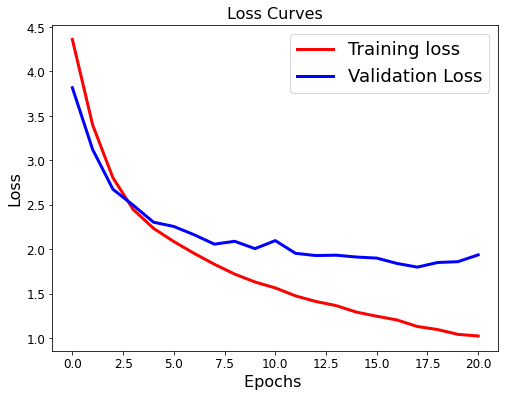

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history_tf3.history['loss'],'r',linewidth=3.0)
plt.plot(history_tf3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'accuracy Curves')

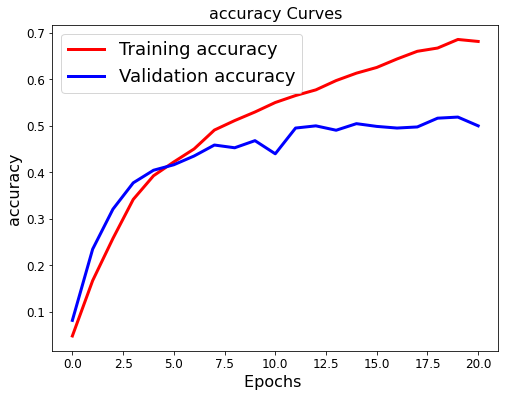

In [ ]:
# accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history_tf3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_tf3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.title('accuracy Curves',fontsize=16)

## Testing

In [ ]:
img = Image.open('/content/drive/MyDrive/LotusPose.png').convert('RGB')

(267, 203, 3)


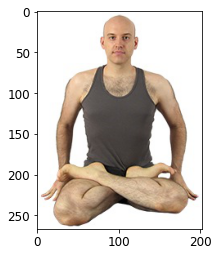

In [ ]:
print(np.array(img).shape)
plt.imshow(np.array(img))

In [ ]:
img.mode

'RGB'

In [ ]:
img = img.resize((224,224),Image.ANTIALIAS)


In [ ]:
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.applications.densenet import preprocess_input


#preprocess the image
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)


In [ ]:
#make the prediction
prediction = model_tf.predict(img)

In [ ]:
np.where(prediction == np.amax(prediction))[1][0]

48

In [35]:
index_mapping[48]

'hero pose'